In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
import skimage.morphology.greyreconstruct as rec
import astropy.io.fits as fits

In [2]:
dc  = fits.getdata('../Documents/dc_00001.fits').astype('float')
img = fits.getdata('../Documents/ct01_00001.fits').astype('float')-dc
ob  = fits.getdata('../Documents/ob_00001.fits').astype('float')-dc

img[img<1]=1
ob[ob<1]=1

timg=img/ob
img=-np.log(timg)

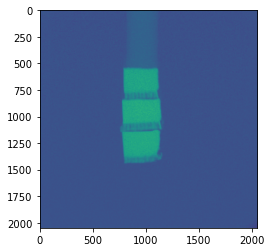

In [3]:
plt.imshow(img)

In [4]:
def fill_hole(img) :
    tmax=img.max()
    fm = img.copy()
    fm[1:-2,1:-2] = tmax
    
    res=rec.reconstruction(fm,img,method='erosion')
    
    return res

In [5]:
def fill_spots(img,size=5) :
    med = flt.median(img,selem=np.ones([size,1]))
    med = flt.median(med,selem=np.ones([1,size]))
    fm = img.copy()
    fm[1:-2,1:-2] = med[1:-2,1:-2]
    fm = np.maximum(fm,img)
    
    res=rec.reconstruction(fm,img,method='erosion')
    
    return res

In [6]:
fp=-fill_spots(-timg)
fh=fill_spots(timg)

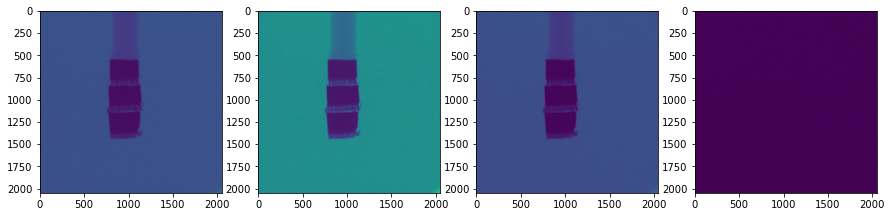

In [8]:
fig,ax =plt.subplots(1,4,figsize=(15,5))
ax[0].imshow(timg)
ax[1].imshow(fp)
ax[2].imshow(fh)
ax[3].imshow(timg-fp)

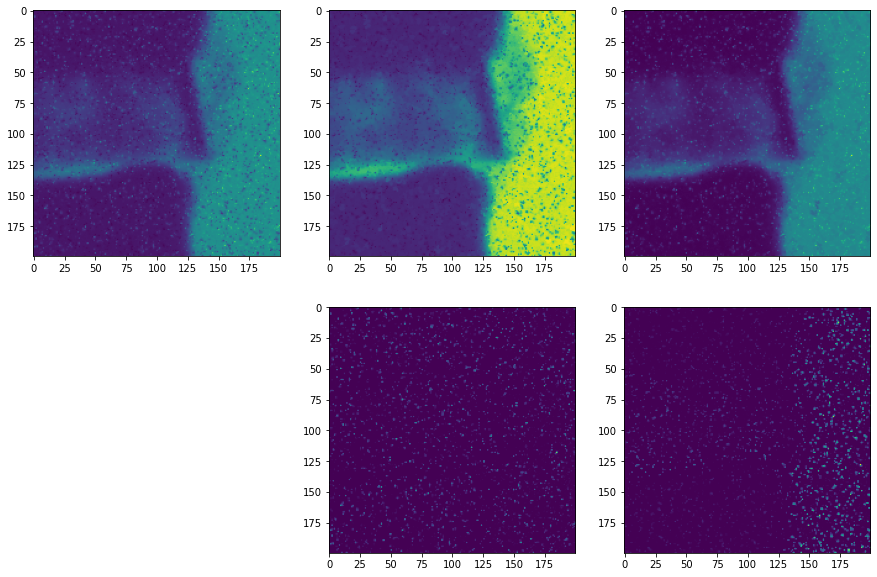

In [10]:
fig,ax =plt.subplots(2,3,figsize=(15,10)); ax=ax.ravel()

dh=np.abs(timg-fh)
dp=np.abs(timg-fp)
ax[0].imshow(timg[1000:1200,1000:1200])
ax[1].imshow(fp[1000:1200,1000:1200])
ax[2].imshow(fh[1000:1200,1000:1200])
ax[3].axis('off')
ax[4].imshow(dp[1000:1200,1000:1200])
ax[5].imshow(dh[1000:1200,1000:1200])


In [11]:
hh,ah=np.histogram(dh.ravel(),bins=1024);
hp,ap=np.histogram(dp.ravel(),bins=1024);

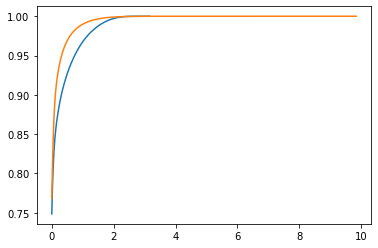

In [12]:
chh=np.cumsum(hh)
plt.plot(ah[:-1],chh/chh[-1])

chp=np.cumsum(hp)
plt.plot(ap[:-1],chp/chp[-1])

In [13]:
ah[np.argmax(0.95<chh/chh[-1])]

0.7387602546036881

In [17]:
def morph_spot_clean(img,th_peaks=0.95,th_holes=0.95) :
    fp=-fill_spots(-img)
    fh=fill_spots(img)
    
    dh=np.abs(img-fh)
    dp=np.abs(img-fp)
    
    hh,ah=np.histogram(dh.ravel(),bins=1024);
    hp,ap=np.histogram(dp.ravel(),bins=1024);
    chh=np.cumsum(hh)
    chp=np.cumsum(hp)
    thh=ah[np.argmax(0.95<chh/chh[-1])]
    thp=ap[np.argmax(0.95<chp/chp[-1])]
    
    res=img.copy()
    res[thh<dh]=fh[thh<dh]
    res[thp<dp]=fp[thp<dp]
    
    return res

In [22]:
c=morph_spot_clean(img,th_peaks=0.95,th_holes=0.95)

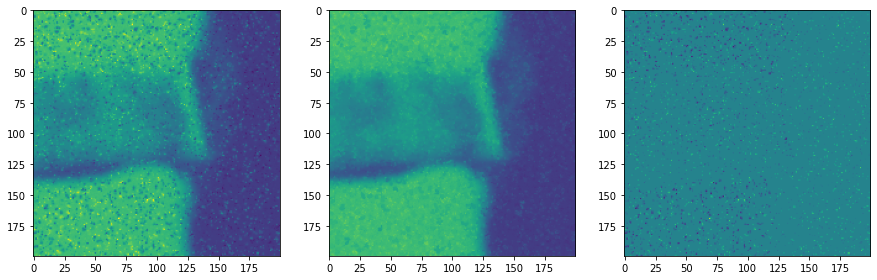

In [28]:
fig,ax =plt.subplots(1,3,figsize=(15,5))
vmin=-2
vmax=2
ax[0].imshow(img[1000:1200,1000:1200],vmin=vmin,vmax=vmax)
ax[1].imshow(c[1000:1200,1000:1200],vmin=vmin,vmax=vmax)
d=img-c
ax[2].imshow(d[1000:1200,1000:1200])


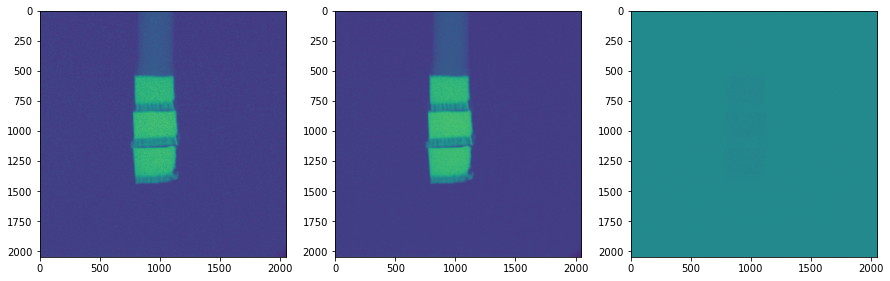

In [29]:
fig,ax =plt.subplots(1,3,figsize=(15,5))
vmin=-2
vmax=2
ax[0].imshow(img,vmin=vmin,vmax=vmax)
ax[1].imshow(c,vmin=vmin,vmax=vmax)
d=img-c
ax[2].imshow(d)